## Cumulative Forecasting for All Counties

In [19]:
from __future__ import print_function
import re
import os
import sys
import git
import math
import matplotlib
import numpy as np
import pandas as pd
from math import sqrt
from tqdm import tqdm
from time import strftime
from datetime import timedelta
import matplotlib.pyplot as plt

from dateutil.parser import parse
import matplotlib.dates as mdates
from pmdarima.arima import auto_arima
from datetime import datetime, date, time 
from sklearn.metrics import mean_squared_error

%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.style.use('ggplot')
pd.options.display.max_rows = 999

In [14]:
FIG_SIZE = (14,10)
DAYS_IN_FUTURE = 15 # Amount of days you want to forecast into future
PERC_SPLIT = 0.95  # Percentage split of training/validation data

### Plotting 

In [15]:

def plot_forecast(tmp_df, train, valid, index_forecast, forecast, confint):
    #For plotting date ranges
    date_1 = datetime.strptime(tmp_df.date.min(), "%Y-%m-%d")
    date_2 = datetime.strptime(tmp_df.date.max(), "%Y-%m-%d") + timedelta(days=DAYS_IN_FUTURE+1)
    date_range = [d.strftime('%Y-%m-%d') for d in pd.date_range(date_1, date_2)]
    date_range = pd.date_range(date_1, date_2)
    
    forecast = pd.DataFrame(forecast, index = index_forecast, columns=['pred'])
    tmp_df = pd.concat([tmp_df, forecast], axis=1, sort=False)
    tmp_df['date'] = pd.Series(date_range).astype(str)
    tmp_df[''] = None #Dates get messed up, so need to use pandas plotting
    
    tmp_df.to_csv('test.csv')
    
    # For shadowing
    lower_series = pd.Series(confint[:, 0], index=index_forecast)
    upper_series = pd.Series(confint[:, 1], index=index_forecast)
    
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    plt.title('Prediction for future cumalitive {} days in the future'.format(DAYS_IN_FUTURE))    
    plt.plot(train, label='Train',marker='o')
    plt.plot(valid, label='Test', marker='o')
    plt.plot(forecast, label='Forecast', marker='o')
    tmp_df.groupby('date')[['']].sum().plot(ax=ax)
    plt.fill_between(index_forecast, 
                     upper_series, 
                     lower_series, 
                     color='k', alpha=.1)
    plt.ylabel('Infections')
    plt.xlabel('Date')
    fig.legend().set_visible(True)
    fig = ax.get_figure()
#     fig.savefig(os.path.join(image_dir, create_save_file(col, country, 'trendline'))

### Build ARIMA model


In [16]:
'''
Train model and to a forecast on the validation
data + the number of days in the future

'''
def forecast(tmp_df, t, v, DAYS_IN_FUTURE):
    train = t.cumulative_cases
    valid = v.cumulative_cases
    index_forecast = [x for x in range(valid.index[0],valid.index[-1] + DAYS_IN_FUTURE+1)]
    
    
    # Fit model with training data
    model = auto_arima(train, trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(train)
        
    print('Forecasting {} days in the future'.format(DAYS_IN_FUTURE))
    # run prediction for 9 days ( 2 days over validation data)
    forecast, confint = model.predict(n_periods=len(index_forecast), return_conf_int=True)
    RMSE = sqrt(mean_squared_error(valid,forecast[:len(valid)]))
    print('RMSE:', RMSE)
    
    plot_forecast(tmp_df, train, valid, index_forecast, forecast, confint)

In [17]:
data_dir = '../data/' + str(datetime.date(datetime.now()))
trend_file  = 'trend_{}.csv'.format(datetime.date(datetime.now()))
df = pd.read_csv(os.path.join(data_dir, trend_file), index_col=0)

df['cumulative_cases'] = df.new_confirmed_cases.cumsum()
df.insert(loc=0, column='day', value=np.arange(1, len(df)+1))
df.set_index('day', inplace=True)

Forecasting 15 days in the future
RMSE: 12269.778568320782


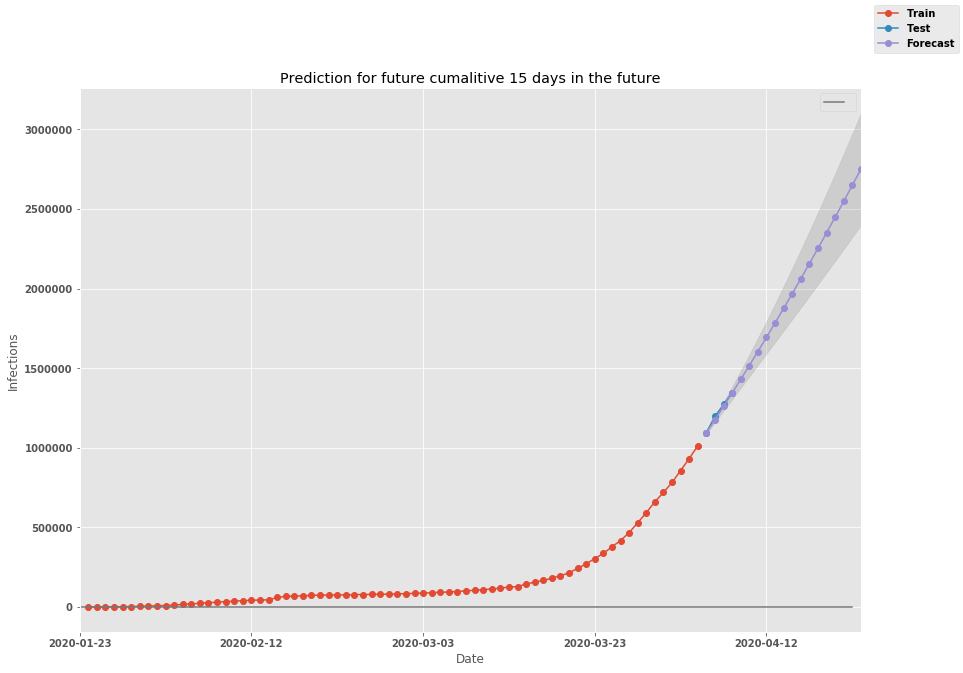

In [18]:
def make_forecast(tmp_df):

    #Split data
    train = tmp_df[:int(PERC_SPLIT*(len(tmp_df)))]
    valid = tmp_df[int(PERC_SPLIT*(len(tmp_df))):]
    forecast(tmp_df, train, valid, DAYS_IN_FUTURE)

make_forecast(df)

In [908]:
# df